In [1]:
!pip install hmmlearn==0.2.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import time
from hmmlearn import hmm
from scipy.stats import entropy
from scipy.special import rel_entr
import matplotlib.pyplot as plt
import csv

In [3]:
class HMM(hmm.MultinomialHMM):

    def __init__(self, n_components):
        super().__init__(n_components)

    def alpha_pass(self, X):
        alphas = self._do_forward_pass(
            self._compute_log_likelihood(X) )[1]
        return alphas

    def beta_pass(self, X):
        betas = self._do_backward_pass(
            self._compute_log_likelihood(X) )
        return betas
    
    def smoothing(self, X, t):
      if t<=0:
        raise ValueError('t must be >=1')
      return self.predict_proba(X)[t-1]
      

In [4]:
def convert_number_system(input_number, input_base, output_base):
    '''
    function that calculates numbers from one base to the other
    returns: int, converted number
    '''
    remainder_list = []
    sum_base_10 = 0
    if output_base == 2:
        binary_repr = bin(input_number)
        return (binary_repr[2:])
    elif input_base != 10:
        reversed_input_number = input_number[::-1]
        hex_helper_dict = {'a' : 10 , 'b' : 11 , 'c' : 12 , 'd' : 13 , 'e' : 14 , 'f' : 15}
        for index, number in enumerate(reversed_input_number):
            for key,value in hex_helper_dict.items():
                if str(number).lower() == key:
                    number = value
            sum_base_10 += (int(number)*(int(input_base)**index))
    elif input_base == 10:
        sum_base_10 = int(input_number)

    while sum_base_10 > 0:
        divided = sum_base_10// int(output_base)
        remainder_list.append(str(sum_base_10 % int(output_base)))
        sum_base_10 = divided
    return_number = ''
    if output_base == 16:
        hex_dict = {10 : 'a' , 11 : 'b' , 12 : 'c' , 13 : 'd' , 14 : 'e' , 15 : 'f'}
        for index, each in enumerate(remainder_list):
            for key, value in hex_dict.items():
                if each == str(key):
                    remainder_list[index] = value
    else:
        for each in remainder_list[::-1]:
            return_number += each

    return (return_number)

def create_seq(y, numStatesOfY, T):
  temp = convert_number_system(y, 10, numStatesOfY)
  templength = len(temp)
  Y = np.zeros(T, dtype=np.int64)
  i = T-templength
  for c in temp:
    Y[i] = ord(c)-48
    i += 1
  return Y

def compute_attack_cost(c, obsLen, currentA):
  cost = 0
  for i in range(obsLen):
    cost += currentA[i]
  return c * cost

def calculate_kl(p_clean, p_att):
  kl = np.sum( rel_entr(p_clean, p_att) )
  return kl

def compute_attack_utility(w1, w2, kl_value, attack_cost):
  utility = (w1 * kl_value) - (w2 * attack_cost)
  return utility

In [5]:
def hmm_algorithm(x, timeOfInterest, S, attack_cost, binomial_value, w1, w2):
  N = transition.shape[0]
  T = len(X)
  M = emission[0].shape[0]
  A = pow(2, T)
  Y_list = []
  
  success_draws = []
  utils = []
  specific_utils = [[0 for _ in range(S)] for _ in range(32)]
  specific_kls = [[0 for _ in range(S)] for _ in range(32)]
  for i in range(0,A):
    utils.append(0)
  for s in range(S):
    success_draw = np.random.binomial(1, binomial_value, 1)
    success_draws.append(success_draw)

    dirichlet_sample = np.random.dirichlet(initial_copy, 1)
    np.copyto(model_new.startprob_, dirichlet_sample)
    for n in range(N):
      temp_transition = np.random.dirichlet(transition_copy[n], 1)[0]
      np.copyto(model_new.transmat_[n], temp_transition)
      temp_emission = np.random.dirichlet(emission_copy[n], 1)[0]
      np.copyto(model_new.emissionprob_[n], temp_emission)
    alpha_x = model_new.alpha_pass(X)
    beta_x = model_new.alpha_pass(X)
    p_clean = model_new.smoothing(X,2)

    y_list = [x[:] for _ in range(32)]
    for a in range(0,A):
      a_list = create_seq(a, 2, T)
      if(success_draw == 1):
        for attack in range(0,len(a_list)):
          if(a_list[attack] == 1 and x[attack] != 2):
            y_list[a][attack] = x[attack] + 1
      
    np.copyto(model_new.startprob_, dirichlet_sample)
    for n in range(N):
      temp_transition = np.random.dirichlet(transition_copy[n], 1)[0]
      np.copyto(model_new.transmat_[n], temp_transition)
      temp_emission = np.random.dirichlet(emission_copy[n], 1)[0]
      np.copyto(model_new.emissionprob_[n], temp_emission)
    
    p_att = []
    kl_s = []
    k = 0
    for y in y_list:
      Y = np.atleast_2d(y).T
      alpha_y = model_new.alpha_pass(Y)
      beta_y = model_new.alpha_pass(Y)
      p_att_y = model_new.smoothing(Y,2)
      p_att_y.tolist()
      res_kl = calculate_kl(p_clean, p_att_y)
      kl_s.append(res_kl)
      specific_kls[k][s] = res_kl
      k+=1
      p_att.append(p_att_y)

    for a in range(0,A):
      a_c_list = create_seq(a, 2, T)
      attack_cost = compute_attack_cost(1, T, a_c_list)
      utility = compute_attack_utility(w1, w2 , kl_s[a], attack_cost)
      specific_utils[a][s] = utility
      utils[a] = utils[a] + utility
      # print("S is : ",s,"Attack Number : ", a, "Utility : ", utility)

  avg_utils = []
  for u in utils:
    avg_utils.append(u/S)
  # print(avg_utils)
  best_utility = avg_utils.index(max(avg_utils))
  optimal_attack = create_seq(best_utility, 2, T)
  print("Optimal attack ", optimal_attack)
  print("Specific Utils for Optimal : ", specific_utils[best_utility])
  ustar_utils = specific_utils[best_utility]
  # -- For Graph1
  # return ustar_utils
  # -- For Graph 2
  # return specific_kls
  

In [6]:
def calculate_ustar_graph(high_ustar, low_ustar):
  data = [['high_ustar', 'low_ustar']]
  for i in range(len(high_ustar)):
    data.append([high_ustar[i], low_ustar[i]])
  fi = '/content/sample_data/Ustar_Values.csv'
  with open(fi, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(data)

  high_ustar.sort()
  low_ustar.sort()
  plt.plot(high_ustar,label='Dirichlet = 100, Binomial = 0.75  (High Unc)')
  plt.plot(low_ustar,label='Dirichlet = 100, Binomial = 0.75 (low Unc)')
  plt.legend()
  plt.tight_layout()
  plt.grid()
  plt.ylabel('Optimal Utility (U*)')
  plt.xlabel('Samples drawn (S)')
  plt.title('1. Change in U* (w1 = 0.8 and w2 = 0.2)')
  plt.show()

In [7]:
def plot_box_kl_attacks(kl_values):
  attack_lists = [[] for _ in range(6)]
  for i in range(0,len(kl_values)):
    binary_index = bin(i)[2:]
    sum_ones = sum(int(bit) for bit in binary_index)
    for j in kl_values[i]:
      attack_lists[sum_ones].append(j)
  print("KL Values : ",attack_lists)

  data = [['Sum of Attacks', 'KL Values']]
  for i in range(0,len(attack_lists)):
    for j in kl_values[i]:
      data.append([i, j])
  fi = '/content/sample_data/KL_Values.csv'
  with open(fi, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(data)

  data = attack_lists
  plt.boxplot(data)
  xtick_labels = plt.xticks()[1]
  new_xtick_labels = [int(label.get_text()) - 1 for label in xtick_labels]
  plt.xticks(range(1, len(xtick_labels) + 1), new_xtick_labels)
  plt.xlabel('No of Poisioned Observations')
  plt.ylabel('Kullback - Leiber Divergence')
  plt.title('2. Distribution Disruption - Low Uncertainity')
  plt.show()

In [8]:
def plot_kl_distributed_disruption_graph(unc_high_kl, unc_low_kl):
  

  # plt.plot(unc_high_kl, w1_w2_values, label='High Uncertainity', color = 'blue')
  # plt.plot(unc_low_kl, w1_w2_values, label='Low Uncertainity', color = 'red')
  # plt.legend()
  # plt.tight_layout()
  # plt.grid()
  # plt.xlabel("Change in W1/W2")
  # plt.ylabel('Kullback - Leiber Divergence')
  # plt.title('3. Distribution Disruption') # As drawn in 5c
  # plt.show()

SyntaxError: ignored

Optimal attack  [0 1 0 0 1]
Specific Utils for Optimal :  [0.8075080406165686, 0.8903904733317379, 0.7955642571454314, 0.8281045143735114, 0.8560683675317534, 0.8367419734451728, 0.787317077202231, 0.8082300396448926, 0.8215367076387347, 0.8528617075939385, 0.8571733470015032, 0.8355890937194274, 0.8454297859897589, 0.8768066468561339, 0.8105828513747965, 0.7644236178622222, 0.8048209740863651, -0.3999484334416139, 0.839545061827108, 0.8767478810178545, 0.8211531314480677, 0.8488877927614632, 0.8409862493869692, 0.7967374560703518, 0.7737591924437847, 0.8106911201981967, 0.7999629363285866, -0.39984437511037735, 0.8430382783597196, 0.7697782374264343, -0.3999969428247867, 0.8076311613051176, 0.7913820970957043, -0.3998214759122305, 0.8605606904448196, 0.8234210562843315, 0.8604821444371303, 0.8608432417141142, 0.847684495038529, 0.8445123621202771, 0.7987553787995499, 0.7874020670188889, 0.7897286921798324, 0.7817411629372958, 0.8231464222063066, 0.8250289097518625, -0.3995002013590489

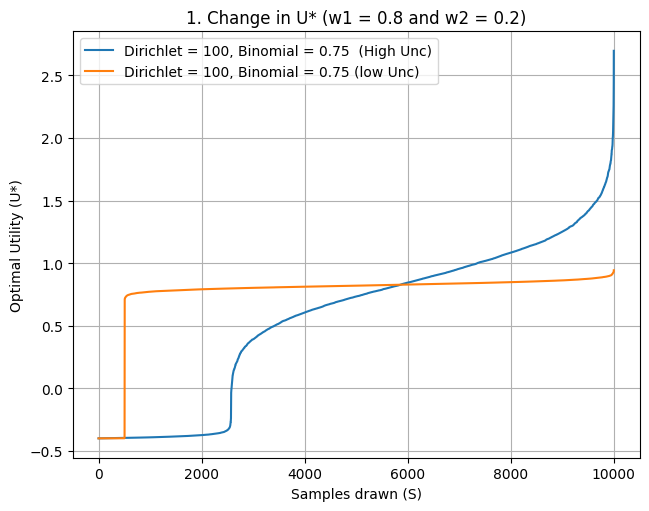

In [10]:
if __name__ == "__main__":
  X = np.atleast_2d([0,1,2,2,1]).T
  xd = X.tolist()
  x = [ele for sublis in xd for ele in sublis]
  
  # -- High Uncertainity run for graph 1
  # dirichlet_precision_k = 100
  # binomial_value = 0.75
  # w1 = 0.8
  # w2 = 0.2

  # -- Low Uncertainity run for graph 1
  # dirichlet_precision_k = 10000
  # binomial_value = 0.95
  # w1 = 0.8
  # w2 = 0.2

  # -- Run for KULL Back Box Plot Graph 2
  # dirichlet_precision_k = 1
  # binomial_value = 0.95
  # w1 = 1
  # w2 = 0.5

  # -- High Uncertainity run for graph 3
  # dirichlet_precision_k = 100
  # binomial_value = 0.75
  # w1 = 1
  # w2 = 0.2

  transition = np.array(((0.8, 0.15, 0.05), (0.7, 0.2, 0.1),(0.05, 0.1, 0.85)))
  emission = np.array(((0.15, 0.8, 0.05), (0.2, 0.5, 0.3),(0.3, 0.2, 0.5)))
  initial = np.array((0.95, 0.04, 0.01))

  transition = transition * dirichlet_precision_k
  emission = emission * dirichlet_precision_k
  initial = initial * dirichlet_precision_k

  transition_copy = transition.copy()
  emission_copy = emission.copy()
  initial_copy = initial.copy()

  model_new = HMM(3)
  model_new.transmat_ = transition
  model_new.emissionprob_ = emission
  model_new.startprob_ = initial

  # -- For U star Graph 1
  # high_ustar = hmm_algorithm(x, 2, 10000, 1, binomial_value, w1, w2)
  # low_ustar = hmm_algorithm(x, 2, 10000, 1, binomial_value, w1, w2)
  # calculate_ustar_graph(high_ustar, low_ustar)

  # -- For Box Plot Graph 2
  # kl_values = hmm_algorithm(x, 2, 1000, 1, binomial_value, w1, w2)
  # plot_box_kl_attacks(kl_values)
